# Model Interpretation
Author: Sridivya Pagadala

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data=pd.read_csv("https://raw.githubusercontent.com/PSdiv/WinQualityData/master/winequality-white.csv",sep=';')

In [ ]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
data.shape

(4898, 12)

In [ ]:
X=data.drop(['quality'],axis=1)
y= pd.DataFrame(data['quality'],columns=['quality'])

#Target Distribution

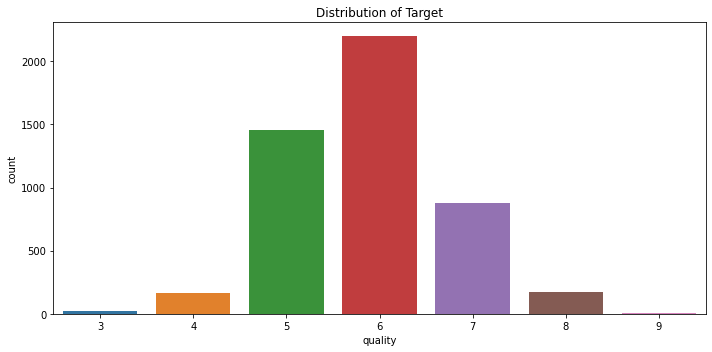

In [ ]:
fig,ax= plt.subplots(figsize=(10,5))
sns.countplot(x=data['quality'])
plt.title("Distribution of Target")
plt.tight_layout()

#Covariance Matrix

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
X_scaled = scale(X)
cov = np.cov(X_scaled, rowvar=False)

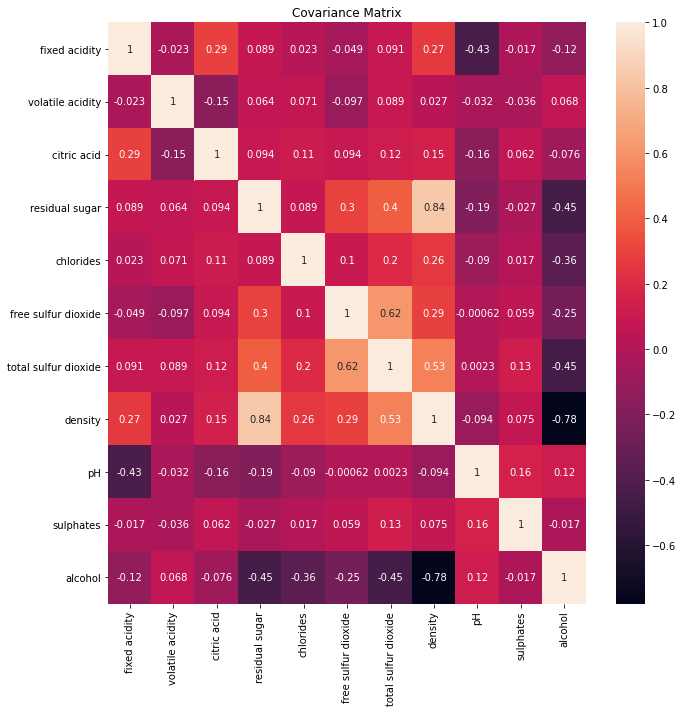

In [ ]:
fig,ax= plt.subplots(figsize=(10,10))
sns.heatmap(data=cov, annot=True,ax=ax,xticklabels=data.drop(['quality'],axis=1).columns, yticklabels=data.drop(['quality'],axis=1).columns)
plt.title("Covariance Matrix")
plt.tight_layout()

#SMOTE Resampling

In [ ]:
from collections import Counter
data['quality'].shape

(4898,)

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
# transform the dataset
oversample = SMOTE(kind='regular',k_neighbors=2)#make_pipeline(RandomOverSampler(),   SMOTE())
X, y = oversample.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

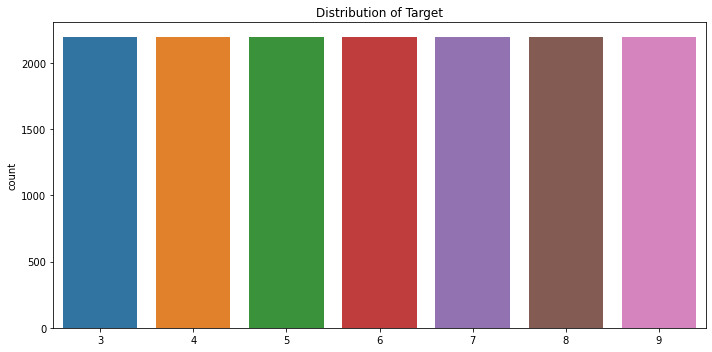

In [ ]:
fig,ax= plt.subplots(figsize=(10,5))
sns.countplot(x=y)
plt.title("Distribution of Target")
plt.tight_layout()

#Train Test Split

In [ ]:
X,X_test,y,y_test=train_test_split(X,y,test_size=0.15)
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.15)
X_train.shape,y_train.shape

((11116, 11), (11116,))

In [ ]:
rf_pipe=Pipeline([('scaler',StandardScaler()),('RandomForest',RandomForestRegressor())])

In [ ]:
score= cross_val_score(rf_pipe,X_train,y_train,scoring='r2',cv=10)
np.mean(score)

0.9561541644164897

In [ ]:
base_model=RandomForestRegressor(n_estimators=100,max_depth=8)
base_model.fit(X_train,y_train)
predictions= base_model.predict(X_valid)
print("MAE Score",mean_absolute_error(y_valid,predictions))
print("Train R2 Score ",base_model.score(X_train,y_train))
print("Validation R2 Score ",base_model.score(X_valid,y_valid))


MAE Score 0.46352279041606265
Train R2 Score  0.8921510763314411
Validation R2 Score  0.8872973032756166


#RandomSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node

min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_depth': [5, 10, 15, 20, 25, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf_random = RandomizedSearchCV(estimator = base_model, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.2min finished


{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 733}

In [ ]:
best_model=RandomForestRegressor(bootstrap= True,
 max_depth= 30,
 min_samples_leaf= 1,
 min_samples_split=5,
 n_estimators= 733)
#Creating Pipeline with best model and Scaling
rf_pipe_best=Pipeline([('scaler',StandardScaler()),('RandomForest',best_model)])

Scores with best model

In [ ]:
train_score= cross_val_score(rf_pipe_best,X_train,y_train,scoring='r2',cv=5)
valid_score= cross_val_score(rf_pipe_best,X_valid,y_valid,scoring='r2',cv=5)
test_score= cross_val_score(rf_pipe_best,X_test,y_test,scoring='r2',cv=5)
print("Best Model Train Score " , np.mean(train_score))
print("Best Model Validation Score ", np.mean(valid_score))
print("Best Model Test Score ", np.mean(test_score))

Best Model Train Score  0.9520059613809517
Best Model Validation Score  0.8835835648422646
Best Model Test Score  0.8881187247174465


#DropFeature Importance

In [ ]:
def drop_feature_importance(est, X, y):
    base_score = np.mean(cross_val_score(est, X, y))
    print(base_score)
    scores = dict()
    for feature in X.columns:
        print(feature)
        # mask = np.ones(X.shape[1], 'bool')
        # mask[feature] = False
        X_new = X.drop([feature],axis=1)
        this_score = np.mean(cross_val_score(est, X_new, y))
        print(this_score)
        scores[feature]=(base_score - this_score)
    return scores

In [ ]:
X_train=pd.DataFrame(X_train,columns=data.drop(['quality'],axis=1).columns)

In [ ]:
scores= drop_feature_importance(rf_pipe_best,X_train,y_train)

0.9520063827952864
fixed acidity
0.9520435750782539
volatile acidity
0.9497081331394757
citric acid
0.9512648410335297
residual sugar
0.9504078722511597
chlorides
0.9504615452169851
free sulfur dioxide
0.9444857329273729
total sulfur dioxide
0.9487681288085893
density
0.951109328536436
pH
0.9493721179885608
sulphates
0.9507896298453312
alcohol
0.9490112849023653


In [ ]:
scores_df= pd.DataFrame(scores.values(),index=X_train.columns,columns=['Feature Drop Score'])
scores_df.sort_values(by='Feature Drop Score',ascending=False,inplace=True)

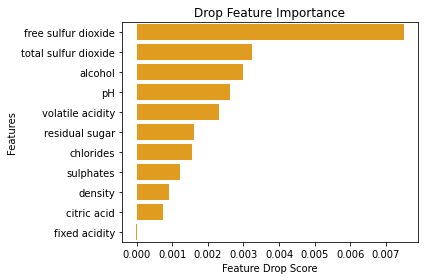

In [ ]:
# Drop feature Imoprtance
sns.barplot(x=scores_df['Feature Drop Score'],y=scores_df.index,color='orange')
plt.title("Drop Feature Importance")
plt.ylabel("Features")
plt.tight_layout()

Summary: free sulfur dioxide, alcohol, total sulfur dioxide, chlorides are top four important features according to this method.

#Permutation Importance

In [ ]:
from sklearn.utils import shuffle
def permutation_importance(est, X, y, n_repeat=10):
  baseline_score = est.score(X,y)
  scores = np.zeros((X.shape[1],n_repeat))
  scores_final=[]
  for f_idx in range(X.shape[1]):
      for repeat in range(n_repeat):
          X_new = X.copy()
          X_new[:, f_idx] = shuffle(X[:, f_idx])
          feature_score = est.score(X_new,y)
          scores[f_idx, repeat] = (baseline_score - feature_score)
          # print(this_score)
      scores_final.append(np.average(scores[f_idx]))
  return scores_final

In [ ]:
best_model.fit(X_train,y_train)
perm_scores=permutation_importance(best_model,X_train.values,y_train)
perm_scores

[0.1299001863538579,
 0.17267750543527188,
 0.14750296029192622,
 0.07108775956548093,
 0.3311883406202881,
 0.39900312013436456,
 0.10992850237675808,
 0.03416125877628147,
 0.13727947487029998,
 0.02792829416317575,
 0.35404411627956994]

In [ ]:
scores_df= pd.DataFrame(perm_scores,index=X_train.columns,columns=['Perm feature score'])
scores_df.sort_values(by='Perm feature score',ascending=False,inplace=True)

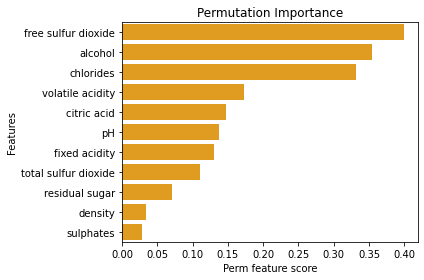

In [ ]:
# fig,axis= plt.subplot()
sns.barplot(x=scores_df['Perm feature score'],y=scores_df.index,color='orange')
plt.title("Permutation Importance")
plt.ylabel("Features")
plt.tight_layout()

Summary: alcohol, free sulfur dioxide, chlorides, volatile acidity are top four important features according to this method.

#Permutation Importance with eli5

In [ ]:
pip install eli5

     |████████████████████████████████| 112kB 1.4MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
rf_pipe_best.fit(X_train,y_train)
perm = PermutationImportance(rf_pipe_best, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
scores_df= pd.DataFrame(perm.feature_importances_,index=X_train.columns,columns=['Feature Score'])
scores_df.sort_values(by='Feature Score',ascending=False,inplace=True)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


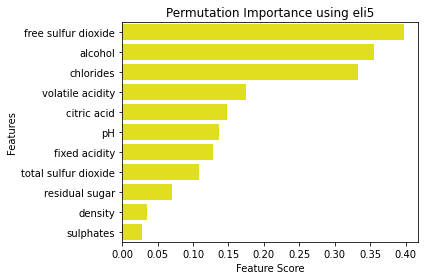

In [ ]:
# fig,axis= plt.subplot()
sns.barplot(x=scores_df['Feature Score'],y=scores_df.index,color='yellow')
plt.title("Permutation Importance using eli5")
plt.ylabel("Features")
plt.tight_layout()

Summary: alcohol, free sulfur dioxide, pH, volatile acidity are top four important features according to this method.

#SHAP

In [ ]:
pip install shap

     |████████████████████████████████| 276kB 1.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394118 sha256=de29021e01ad0793c503f4812ac8b01695db9f11d98699dd3ff2435bbb495656
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


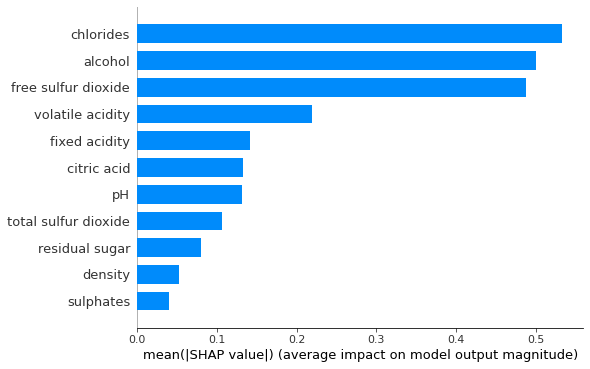

In [ ]:
import shap
best_model.fit(X_train,y_train)
shap_values = shap.TreeExplainer(best_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Force Plot

In [ ]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

Summary plot

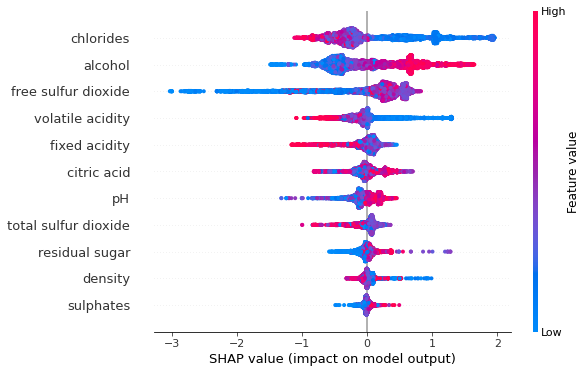

In [ ]:
shap.summary_plot(shap_values, X_train)

Single feature Per Sample Explanation 

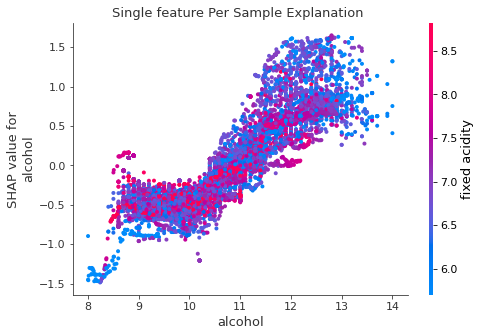

In [ ]:
shap.dependence_plot("alcohol", shap_values, X_train ,interaction_index=0,title= "Single feature Per Sample Explanation ")

Summary: SHAP allows marginal per category importance on output. It also shows Per sample explanations with respect to output

#Partial Dependence plots

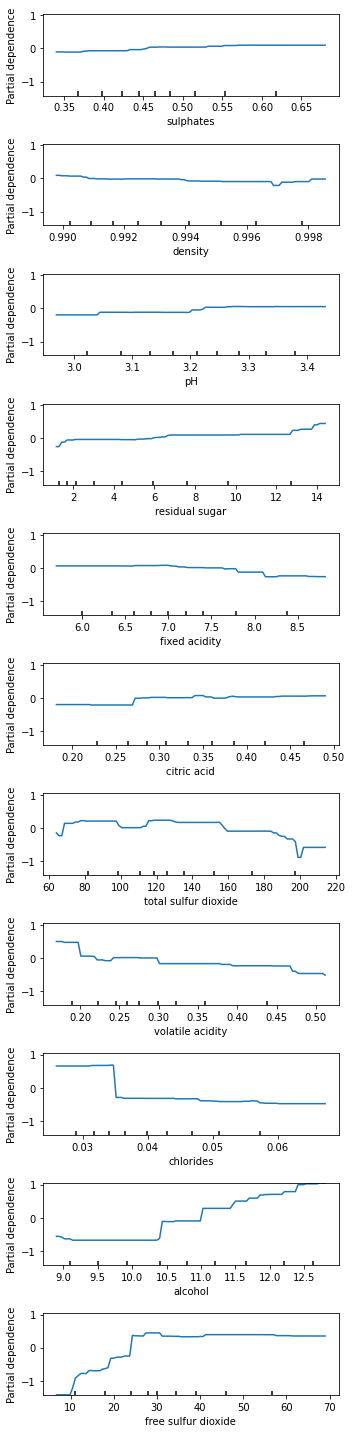

In [ ]:
from sklearn.inspection import plot_partial_dependence

gbrt = GradientBoostingRegressor().fit(X_train, y_train)
fig,ax = plt.subplots(11,figsize=(5,20))


plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_), feature_names=X_train.columns,ax=ax)

plt.tight_layout()


Summary: alcohol, volatile acidity feature curves has more change in dependencies compared to other hence these two are the important features according to this method.

#ICE Plot

In [ ]:
pip install pycebox

  Created wheel for pycebox: filename=pycebox-0.0.1-cp36-none-any.whl size=3644 sha256=04bd70340c07cc4559c92419b63962e4ae3e0798023b76713b37565d7b6b7cd3
  Stored in directory: /root/.cache/pip/wheels/58/5e/65/001126ca8b1f5c71e9571d09ba579e82bb0792062e7a82e77c
Successfully built pycebox


In [ ]:
from pycebox.ice import ice, ice_plot

In [ ]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

ICE for one Feature

In [ ]:
ice_df = ice(X_train, 'free sulfur dioxide', gbm.predict, num_grid_points=100)

In [ ]:
ice_df.head()

data_free sulfur dioxide 2.000000   2.819972    ... 287.236038 287.499223
fixed acidity              6.500000   6.609330  ...   6.117396   6.114801
volatile acidity           0.270000   0.267267  ...   0.262018   0.261717
citric acid                0.260000   0.277766  ...   0.250696   0.250592
residual sugar            11.000000  10.371355  ...  2.988024   2.974891 
chlorides                  0.030000   0.030547  ...   0.047070   0.047059
total sulfur dioxide     82.000000  82.273324   ... 439.488555 439.564863
density                    0.994020   0.994045  ...   0.993188   0.993181
pH                         3.070000   3.085033  ...   3.437217   3.437632
sulphates                  0.360000   0.373666  ...   0.639930   0.639941
alcohol                   11.200000  11.240999  ...  10.503479  10.502960
free sulfur dioxide                             ...                      
2.000000                   5.723162   5.940772  ...   4.439885   4.439885
5.000000                   5.723162   5.940772  ...   4.439885   4.439885
5.105087                   5.723162   5.940772  ...   4.439885   4.439885
6.000000                   5.780364   5.997974  ...   4.623039   4.623039
6.744692                   5.780364   5.997974  ...   4.623039   4.623039

[5 rows x 9717 columns]

#ICE Plot Method

In [ ]:
def ice_plot(ice_data, frac_to_plot=1.,
             plot_points=False, point_kwargs=None,
             x_quantile=False, plot_pdp=False,
             centered=False, centered_quantile=0.,
             color_by=None, cmap=None,
             ax=None, pdp_kwargs=None, **kwargs):
    """
    Plot the ICE curves
    :param ice_data: the ICE data generated by :func:`pycebox.ice.ice`
    :type ice_data: ``pandas`` ``DataFrame``
    :param frac_to_plot: the fraction of ICE curves to plot.  If less than one,
        randomly samples columns of ``ice_data`` to plot.
    :type frac_to_plot: ``float``
    :param plot_points: whether or not to plot the original data points on the
        ICE curves.  In this case, ``point_kwargs`` is passed as keyword
        arguments to plot.
    :type plot_points: ``bool``
    :param x_quantile: if ``True``, the plotted x-coordinates are the quantiles of
        ``ice_data.index``
    :type x_quantile: ``bool``
    :param plot_pdp: if ``True``, plot the partial depdendence plot.  In this
        case, ``pdp_kwargs`` is passed as keyword arguments to ``plot``.
    :param centered: if ``True``, each ICE curve is centered to zero at the
        percentile closest to ``centered_quantile``.
    :type centered: ``bool``
    :param color_by:  If a string, color the ICE curve by that level of the
        column index.
        If callable, color the ICE curve by its return value when applied to a
        ``DataFrame`` of the column index of ``ice_data``
    :type color_by: ``None``, ``str``, or callable
    :param cmap:
    :type cmap: ``matplotlib`` ``Colormap``
    :param ax: the ``Axes`` on which to plot the ICE curves
    :type ax: ``None`` or ``matplotlib`` ``Axes``
    Other keyword arguments are passed to ``plot``
    """
    if not ice_data.index.is_monotonic_increasing:
        ice_data = ice_data.sort_index()

    if centered:
        quantiles = _get_quantiles(ice_data.index)
        centered_quantile_iloc = np.abs(quantiles - centered_quantile).argmin()
        ice_data = ice_data - ice_data.iloc[centered_quantile_iloc]

    if frac_to_plot < 1.:
        n_cols = ice_data.shape[1]
        icols = np.random.choice(n_cols, size=int(frac_to_plot * n_cols), replace=False)
        plot_ice_data = ice_data.iloc[:, icols]
    else:
        plot_ice_data = ice_data


    if x_quantile:
        x = _get_quantiles(ice_data.index)
    else:
        x = ice_data.index

    if plot_points:
        point_x_ilocs = _get_point_x_ilocs(plot_ice_data.index, plot_ice_data.columns)
        point_x = x[point_x_ilocs]
        point_y = plot_ice_data.values[point_x_ilocs, np.arange(point_x_ilocs.size)]

    if ax is None:
        _, ax = plt.subplots()

    if color_by is not None:
        if isinstance(color_by, six.string_types):
            colors_raw = plot_ice_data.columns.get_level_values(color_by).values
        elif hasattr(color_by, '__call__'):
            col_df = pd.DataFrame(list(plot_ice_data.columns.values), columns=plot_ice_data.columns.names)
            colors_raw = color_by(col_df)
        else:
            raise ValueError('color_by must be a string or function')

        norm = colors.Normalize(colors_raw.min(), colors_raw.max())
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):
            c = m.to_rgba(color_raw)
            ax.plot(x, ice_curve, c=c, zorder=0, **kwargs)
    else:
        ax.plot(x, plot_ice_data, zorder=0, **kwargs)

    if plot_points:
        ax.scatter(point_x, point_y, zorder=10, **(point_kwargs or {}))

    if plot_pdp:
        pdp_kwargs = pdp_kwargs or {}
        pdp_data = pdp(ice_data)
        ax.plot(x, pdp_data, **pdp_kwargs)

    return ax


#ICE Plots for all the features 

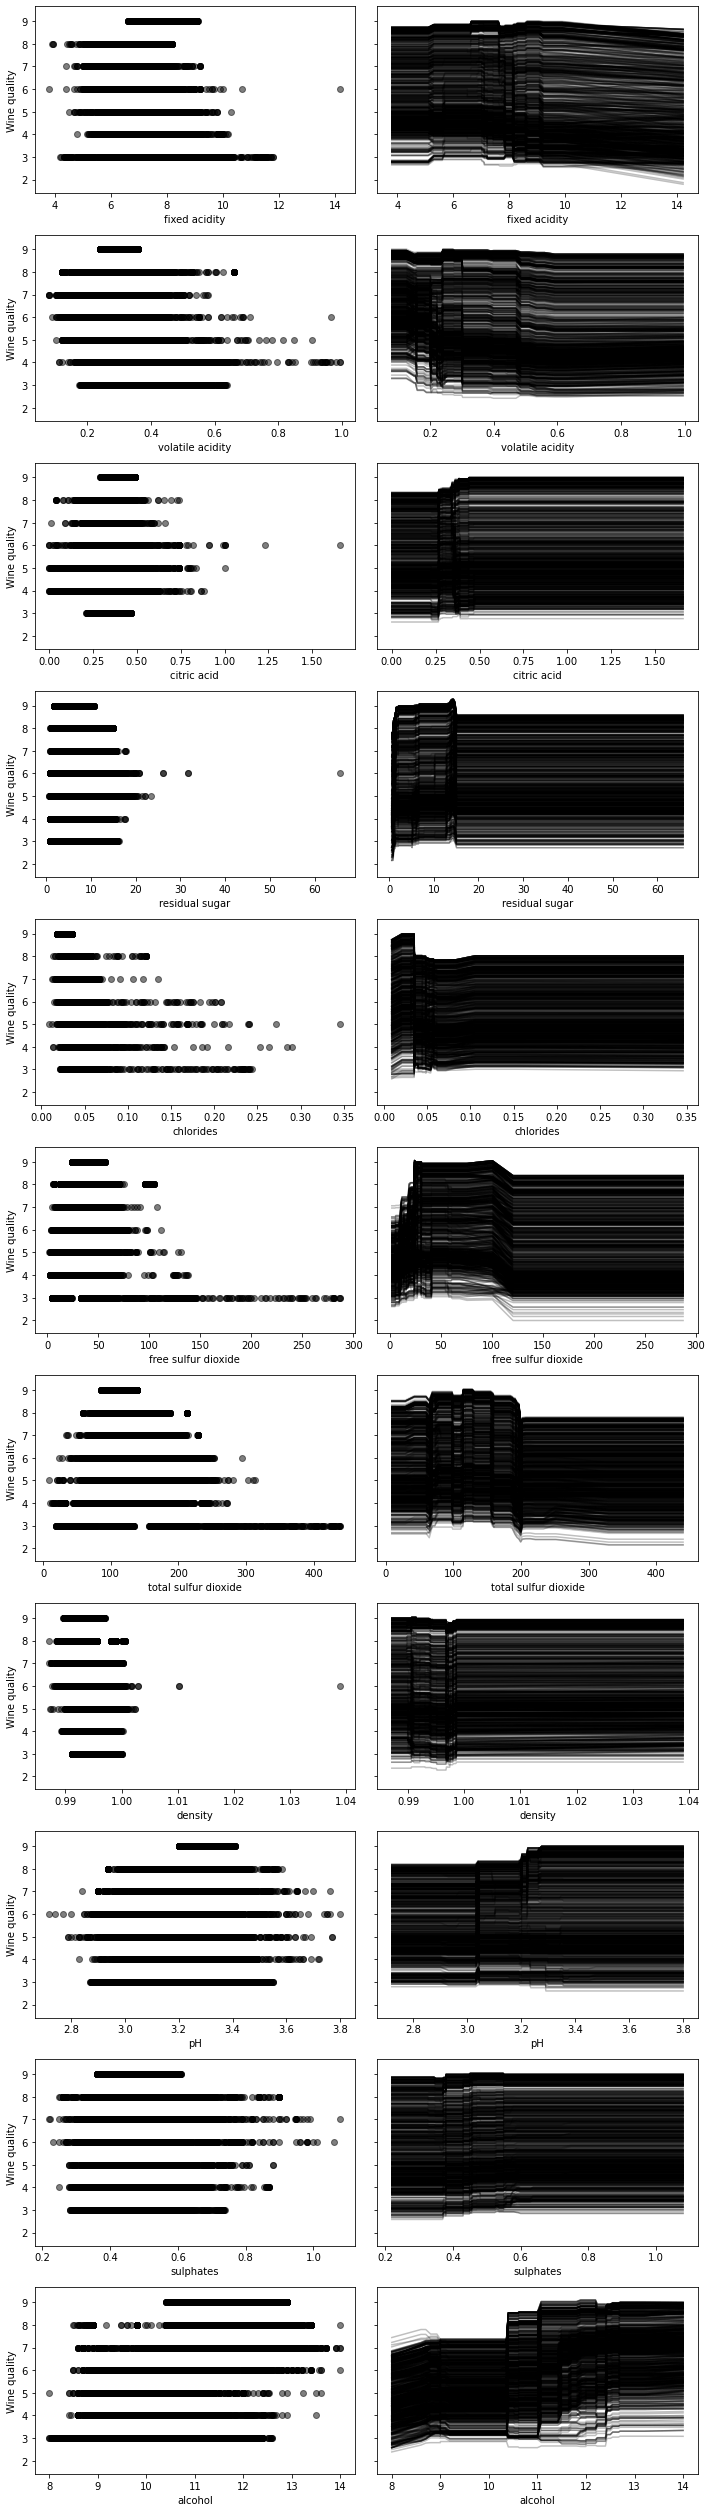

In [ ]:
fig, ice_ax = plt.subplots(nrows=len(X_train.columns) ,ncols=2, sharey=True, figsize=(10,35 ))
# plt.suptitle("Data Vs ICE plot")  
for idx in range(len(X_train.columns)):
  ice_df = ice(data= X_train,  column= X_train.columns[idx] ,predict=gbm.predict , num_grid_points=100 )
  ice_ax[idx][0].scatter(x=X_train[X_train.columns[idx]],y= y_train, c='k', alpha=0.5);
  ice_plot(ice_df, frac_to_plot=0.1,
         c='k', alpha=0.25,
         ax=ice_ax[idx][1]);
  ice_ax[idx][0].set_ylabel("Wine quality")
  ice_ax[idx][0].set_xlabel(X_train.columns[idx])
  ice_ax[idx][1].set_xlabel(X_train.columns[idx])


plt.tight_layout()


Summary: To investigate more on partial dependence plots for per sample performance 

#Summary

I think SHAP and ICE are the best methods for model interpretability because both allow per sample explanations and also SHAP calculates per feature/per category marginalization on subsets of data that means it calculates feature importance without loosing much information from the data compared to other Permutation and DropFeature importance techniques.   